# PJME Hourly Load Forecasting: Hybrid Prophet-XGBoost Model

This notebook demonstrates a hybrid modeling approach for PJME hourly load forecasting. We combine time series feature engineering and Prophet-based preprocessing with an XGBoost regression model to improve forecast accuracy.

## Workflow Overview

1. **Data Loading & Feature Engineering**
    - Load and preprocess PJME hourly load data.
    - Create time-based features (hour, day of week, quarter, etc.).
    - Identify and handle outliers and hurricane events.

2. **Train/Test Split**
    - Split the data into training and test sets based on a cutoff date.

3. **Prophet Preprocessing**
    - Use Prophet to model trend, seasonality, and holiday effects.
    - Extract Prophet's predictions and residuals as additional features.

4. **Hybrid Model: XGBoost**
    - Train an XGBoost regressor using engineered features and Prophet outputs.
    - Evaluate performance on the test set.

## Key Variables

- `df`: Original dataframe with time-based features.
- `train_set`, `test_set`: Split datasets for model training and evaluation.
- `cleaned_train_set`: Outlier-cleaned training data.
- `hurricane_dates`: DataFrame of hurricane event windows.
- `best_params`: Dictionary of optimal parameters for preprocessing.
- `output_dir`: Directory for saving intermediate and final results.

---

**Notes:**  
1. adding monthly to prophet model (horizon= 2y) gave negligible difference.

2. It seems that forecasting a horizon of 3 years is definately bad.
    - model is unlikely to capture newer trends, and may be stuck to older ones.
    - Seasonal/Trend Shifts Over Long Horizons

**Next Steps:**  
- train-test-split: train(2002-2016) / test(2017-2018)
- maybe reevaluate MAPE: 
    - with shorter horizons.
    - maybe compare 1/2/3/4/5 months.
    - use cross-validation for the entire year


- Implement the XGBoost hybrid model using the engineered features and Prophet outputs.



In [22]:
# import libraries and modules
import os
import json
import optuna
import plotly
import pickle
import joblib
import kaleido
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from utils.data_utils import *
from utils.model_utils import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load df 

output_dir = 'output_hybrid_v2'


df = load_data('data/PJME_hourly.csv')

# train_set, test_set = split_train_test(df, '2017-01-01') #cut-off date 

In [4]:
# make sure ds is in ascending order
df = df.sort_values(by='ds').reset_index(drop=True)

check_missing_hours(df)

Missing timestamps: 30/145392
2002-04-07 03:00:00
2002-10-27 02:00:00
2003-04-06 03:00:00
2003-10-26 02:00:00
2004-04-04 03:00:00
2004-10-31 02:00:00
2005-04-03 03:00:00
2005-10-30 02:00:00
2006-04-02 03:00:00
2006-10-29 02:00:00
2007-03-11 03:00:00
2007-11-04 02:00:00
2008-03-09 03:00:00
2008-11-02 02:00:00
2009-03-08 03:00:00
2009-11-01 02:00:00
2010-03-14 03:00:00
2010-11-07 02:00:00
2010-12-10 00:00:00
2011-03-13 03:00:00
2011-11-06 02:00:00
2012-03-11 03:00:00
2012-11-04 02:00:00
2013-03-10 03:00:00
2013-11-03 02:00:00
2014-03-09 03:00:00
2015-03-08 03:00:00
2016-03-13 03:00:00
2017-03-12 03:00:00
2018-03-11 03:00:00


### Analysis of Missing Timestamps

The list of missing timestamps in the dataset (e.g., `2002-04-07 03:00:00`, `2002-10-27 02:00:00`, etc.) strongly suggests that these gaps are due to Daylight Saving Time (DST) transitions. Typically, during the "spring forward" transition, clocks skip from 2:00 AM to 3:00 AM, resulting in the absence of the 2:00–3:00 AM hour. Conversely, during the "fall back" transition, the 2:00 AM hour is repeated, which can sometimes cause duplicate or ambiguous timestamps.

The pattern and timing of the missing hours align with the expected DST changes in the United States, indicating that the dataset is missing hours due to these time adjustments rather than random data loss.

**Note**
- For 'lagging' and other features to be used in XGBoost

In [5]:
df

,ds,y
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0
...,...,...
145361,2018-08-02 20:00:00,44057.0
145362,2018-08-02 21:00:00,43256.0
145363,2018-08-02 22:00:00,41552.0
145364,2018-08-02 23:00:00,38500.0


In [6]:
# Set 'ds' as index for time-based operations
df = df.set_index('ds')

# Print the number of duplicate timestamps
print("Number of duplicates:", df.index.duplicated().sum())

# Print all rows that are duplicates (excluding the first occurrence)
print("Duplicate rows:")
print(df[df.index.duplicated(keep=False)])

Number of duplicates: 4
Duplicate rows:
                           y
ds                          
2014-11-02 02:00:00  23755.0
2014-11-02 02:00:00  22935.0
2015-11-01 02:00:00  21567.0
2015-11-01 02:00:00  21171.0
2016-11-06 02:00:00  20795.0
2016-11-06 02:00:00  21692.0
2017-11-05 02:00:00  21236.0
2017-11-05 02:00:00  20666.0


## Handling Duplicate Timestamps and DST-Related Gaps

During Daylight Saving Time transitions, two issues occur:

1. **“Fall-back” duplicates**  
   In autumn, clocks move back one hour. For example, on `2014-11-02`, two different load readings share the timestamp `02:00:00`. Leaving both rows creates ambiguity for lagged features, since “one hour ago” could refer to either reading.

2. **“Spring-forward” gaps**  
   In spring, clocks skip ahead one hour. For example, `2002-04-07 03:00:00` is missing. Any operation that assumes a continuous hourly index (e.g. `.shift(1)` or `.rolling(24)`) fails at these gaps.

---

### Resolving Duplicate Timestamps

- **Cause:** Two readings for the same nominal hour occur when the clock is set back.  
- **Solution:** Aggregate duplicates by taking their mean. This preserves information from both readings rather than dropping one arbitrarily.


In [7]:
# simple linear (time) interpolation 

# Identify and aggregate duplicates by taking the mean of 'y'
df = df.groupby(level=0).mean()

# Create complete hourly index
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to include all timestamps
df = df.reindex(full_range)

# Interpolate and fill
df['y'] = df['y'].interpolate(method='time')
df['y'] = df['y'].ffill().bfill()

df = df.reset_index().rename(columns={'index': 'ds'})
df['ds'] = pd.to_datetime(df['ds'])  # Ensure it's datetime
check_missing_hours(df)

Missing timestamps: 0/145392


In [8]:
# Basic Feature engineering
df = create_features(df)

In [9]:
train_set, test_set = split_train_test(df,'2017-08-01')

print(f"train_set: {train_set['ds'].min()} to {train_set['ds'].max()}")
print(f"test_set : {test_set['ds'].min()} to {test_set['ds'].max()}")

train_set: 2002-01-01 01:00:00 to 2017-07-31 23:00:00
test_set : 2017-08-01 00:00:00 to 2018-08-03 00:00:00


In [10]:
from pandas.tseries.offsets import MonthEnd

def split_test_set_by_month(test_set):
    """
    Splits the test_set DataFrame into a list of DataFrames, each containing one month of data.
    Returns: List of DataFrames, one per month in test_set.
    """
    
    months = test_set['ds'].dt.to_period('M').unique()
    print(f"Total splits: {len(months)}")

    monthly_splits = []
    for month in months:
        mask = test_set['ds'].dt.to_period('M') == month
        monthly_splits.append(test_set[mask])

        first = test_set[mask]['ds'].min()
        last = test_set[mask]['ds'].max()

        print(f"Month: {month}")
        print(f"{first} to {last} \n")

    return monthly_splits

def rolling_test_horizons(test_set, max_months=12):
    """
    For each horizon from 1 to max_months, returns a list of DataFrames,
    where each DataFrame contains the first N months of the test set.
    """
    start = test_set['ds'].min()
    horizons = []
    for n in range(1, max_months + 1):
        end = (start + MonthEnd(n))
        mask = (test_set['ds'] >= start) & (test_set['ds'] <= end)
        horizons.append(test_set[mask])
    return horizons

In [ ]:
monthly_splits = split_test_set_by_month(test_set)

# Drop last partial month if it's shorter than a full month (e.g., < 28 days)
full_month_splits = [df for df in monthly_splits if len(df) >= 28 * 24]

# full_month_splits[-1]['ds'].min()

Total splits: 13
Month: 2017-08
2017-08-01 00:00:00 to 2017-08-31 23:00:00 

Month: 2017-09
2017-09-01 00:00:00 to 2017-09-30 23:00:00 

Month: 2017-10
2017-10-01 00:00:00 to 2017-10-31 23:00:00 

Month: 2017-11
2017-11-01 00:00:00 to 2017-11-30 23:00:00 

Month: 2017-12
2017-12-01 00:00:00 to 2017-12-31 23:00:00 

Month: 2018-01
2018-01-01 00:00:00 to 2018-01-31 23:00:00 

Month: 2018-02
2018-02-01 00:00:00 to 2018-02-28 23:00:00 

Month: 2018-03
2018-03-01 00:00:00 to 2018-03-31 23:00:00 

Month: 2018-04
2018-04-01 00:00:00 to 2018-04-30 23:00:00 

Month: 2018-05
2018-05-01 00:00:00 to 2018-05-31 23:00:00 

Month: 2018-06
2018-06-01 00:00:00 to 2018-06-30 23:00:00 

Month: 2018-07
2018-07-01 00:00:00 to 2018-07-31 23:00:00 

Month: 2018-08
2018-08-01 00:00:00 to 2018-08-03 00:00:00 



Timestamp('2018-07-01 00:00:00')

In [28]:
#Optuna study
results = {}

def objective(trial):
    """
    Objective function to optimize Prophet model hyperparameters along with the cleaning parameters.

    Uses cross-validation with specified settings and returns the mean MAPE.
    """
    # Clean the training data using hyperparameter suggestions from the trial
    cleaned_train, hurricane_dates = clean_train_data(trial, train_set)
    
    # Prophet hyperparameter suggestions from the trial
    prophet_params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.05, log=True),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.3, 0.9),
        'n_changepoints': trial.suggest_int('n_changepoints', 10, 50),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 5.0, log=True),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.5, 12),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 4, 12)
    }
    
    # Initialize the Prophet model using the provided parameters and hurricane dates
    model = Prophet(
        **prophet_params,
        holidays=hurricane_dates,
        daily_seasonality=False,
        weekly_seasonality=False
        )
    model.add_country_holidays('US')
    
    # Fit the model on the cleaned training data.
    try:
        model.fit(cleaned_train)
    except Exception as e:
        print(f"Fitting failed: {str(e)}")
        return 100.0  # Return a high error if the fitting fails
    
    # Perform cross-validation to evaluate the model's performance
    try:
        df_cv = cross_validation(
            model,
            initial='730 days',
            period='180 days',
            horizon='365 days',
            disable_tqdm=True,
            parallel="processes"
        )              
        df_p = performance_metrics(df_cv, rolling_window=1)
        mape_cv = df_p['mape'].mean()
    except Exception as e:
        print(f"Validation failed: {str(e)}")
        mape_cv = 100.0  # Penalize invalid configurations

    forecast_train = model.predict(cleaned_train)
    forecast_test = model.predict(test_set)
    mape_train, mape_test, residuals_train, residuals_test = get_MAPE(cleaned_train, test_set, 
                                                                      forecast_train, forecast_test, 
                                                                      show=False)
    
    # Save the results into the results dict
    results[trial.number]  = {
        'trial_number' : trial.number,
        'mape_cv' : mape_cv,
        'mape_train' : mape_train,
        'mape_test' : mape_test,
        'residuals_train' : residuals_train,
        'residuals_test' : residuals_test,
        'params' : prophet_params
    }
    
    return mape_cv


In [ ]:
import time

if __name__ == "__main__":

    # Create an Optuna study to minimize MAPE
    timestamp = int(time.time())
    study_name = f"Prophet_optimization_{timestamp}"
    storage_name = f"sqlite:///{output_dir}/{study_name}.db"

    study = optuna.create_study(
        direction='minimize',
        study_name=study_name,
        storage=storage_name,
        sampler=optuna.samplers.TPESampler(seed=42)
    )

    # try:
    #     # Try loading existing study
    #     study = optuna.load_study(
    #         study_name="Prophet_II_study",
    #         storage=f"sqlite:///{output_dir}/Prophet_II_study.db"
    #     )
    #     print("Resuming existing study")
    # except KeyError:
    #     # Create new study if doesn't exist
    #     study = optuna.create_study(
    #         direction='minimize',
    #         study_name="Prophet_II_study",
    #         storage=f"sqlite:///{output_dir}/Prophet_II_study.db",
    #         sampler=optuna.samplers.TPESampler(seed=42)
    #     )
    #     print("Created new study")

    # Optimize the objective function 
    study.optimize(objective, n_trials=3, timeout=3600 * 6)

    # Get best parameters
    best_params = study.best_params
    best_cleaning_params = {
        'window_size': best_params['window_size'],
        'iqr_multiplier': best_params['iqr_multiplier'],
        'hurricane_window': best_params['hurricane_window']
    }
    best_prophet_params = {
        k: best_params[k] for k in [
            'changepoint_prior_scale',
            'changepoint_range',
            'n_changepoints',
            'seasonality_prior_scale',
            'holidays_prior_scale',
            'seasonality_mode',
            'yearly_seasonality'
        ]
    }

    # Save parameters
    with open(os.path.join(output_dir, 'best_cleaning_params.json'), 'w') as f:
        json.dump(best_cleaning_params, f, indent=2)
    with open(os.path.join(output_dir, 'best_prophet_params.json'), 'w') as f:
        json.dump(best_prophet_params, f, indent=2)


    # Verification and model saving
    cleaned_train, hurricane_dates = clean_train_data(best_cleaning_params, train_set)
    final_model = Prophet(
        **best_prophet_params,
        holidays=hurricane_dates,
        daily_seasonality=False,
        weekly_seasonality=False
    )
    final_model.add_country_holidays('US')
    final_model.fit(cleaned_train)
    
    # Recompute CV MAPE
    try:
        df_cv = cross_validation(
            final_model,
            initial='730 days',
            period='180 days',
            horizon='365 days',
            disable_tqdm=True,
            parallel="processes"
        )
        df_p = performance_metrics(df_cv, rolling_window=1)
        verified_mape = df_p['mape'].mean()
    except Exception as e:
        print(f"Verification failed: {str(e)}")
        verified_mape = 100.0

    # Compare to original
    original_mape = study.best_value
    print(f"\nVerification:")
    print(f"Original best MAPE: {original_mape*100:.6f}%")
    print(f"Recomputed MAPE:   {verified_mape*100:.6f}%")
    print(f"Difference:        {(verified_mape - original_mape)*100:.6f}%")
    
    # Save model if verification passes
    if abs(verified_mape - original_mape) < 0.005:
        model_path = os.path.join(output_dir, 'prophet_final_model.pkl')
        joblib.dump(final_model, model_path)
        print("Verification success!!")
        print(f"Model saved to {model_path}")
    else:
        print("Verification failed! Model not saved.")
    
    # Save study visualization
    fig = optuna.visualization.plot_optimization_history(study)
    fig.write_image(os.path.join(output_dir, 'optimization_history.png'))
           

    # Save param importances visualization
    fig = optuna.visualization.plot_param_importances(study,params=list(best_params.keys()))
    fig.write_image(os.path.join(output_dir, 'param_importances.png'))

    print(f"Best trial #: {study.best_trial.number}")     
    print(f"Best MAPE (Cross-Validation): {study.best_value * 100:.2f}%") 
    print("Best params:")
    for key, value in best_params.items():
        print(f"- {key}: {value}")


    # Print summary
    print(f"\nBest trial: #{study.best_trial.number}")
    print(f"Best params:")
    for k, v in best_params.items():
        print(f"- {k}: {v}")

[I 2025-06-06 22:56:58,523] A new study created in RDB with name: Prophet_optimization_1749243418
22:57:37 - cmdstanpy - INFO - Chain [1] start processing
22:57:52 - cmdstanpy - INFO - Chain [1] done processing
22:58:05 - cmdstanpy - INFO - Chain [1] start processing
22:58:06 - cmdstanpy - INFO - Chain [1] start processing
22:58:06 - cmdstanpy - INFO - Chain [1] start processing
22:58:06 - cmdstanpy - INFO - Chain [1] start processing
22:58:08 - cmdstanpy - INFO - Chain [1] done processing
22:58:12 - cmdstanpy - INFO - Chain [1] done processing
22:58:14 - cmdstanpy - INFO - Chain [1] done processing
22:58:15 - cmdstanpy - INFO - Chain [1] start processing
22:58:16 - cmdstanpy - INFO - Chain [1] done processing
22:58:19 - cmdstanpy - INFO - Chain [1] start processing
22:58:22 - cmdstanpy - INFO - Chain [1] start processing
22:58:24 - cmdstanpy - INFO - Chain [1] start processing
22:58:27 - cmdstanpy - INFO - Chain [1] done processing
22:58:30 - cmdstanpy - INFO - Chain [1] done processi

In [ ]:
# # testing different fourier orders for monthly seasonality
# fourier_orders = [3, 5, 7, 10]
# results = {}

# for fourier_order in fourier_orders:
#     print(f"\nTesting fourier_order = {fourier_order}")

#     model = Prophet(
#         **prophet_params,
#         holidays=hurricane_dates,
#         daily_seasonality=False,
#         weekly_seasonality=False
#     )
#     # add us_holidays
#     model.add_country_holidays('US')

#     # add monthly seasonality
#     model.add_seasonality(
#         name='monthly',
#         period=30.437,
#         fourier_order=fourier_order
#     )

#     # time the training
#     start_time = time()
#     model.fit(cleaned_train_set)
#     train_time = time() - start_time
#     print(f"Training time: {train_time:.2f} seconds")

#     # time the forecast
#     start_time = time()
#     forecast_train = model.predict(cleaned_train_set)
#     forecast_time = time() - start_time
#     print(f"Forecasting time: {train_time:.2f} seconds")

#     #Calc MAPE for both train and test set
#     MAPE_train, MAPE_test, residuals_train, residuals_test = get_MAPE(train_set, test_set, forecast_train, 
#                                                                       forecast_test=model.predict(test_set), show=False)

#     print(f"Train_MAPE: {MAPE_train}")
#     print(f"Test_MAPE: {MAPE_test}")
#     print(f"Train_Residuals: {residuals_train}")
#     print(f"Test_Residuals: {residuals_test}")

#     results[fourier_order] = {
#         'model': model,
#         'MAPE_train': MAPE_train,
#         'MAPE_test': MAPE_test,
#         'Residuals_train': residuals_train,
#         'Residuals_test': residuals_test
#     }


Testing fourier_order = 3


03:36:31 - cmdstanpy - INFO - Chain [1] start processing
03:37:39 - cmdstanpy - INFO - Chain [1] done processing


Training time: 83.80 seconds
Forecasting time: 83.80 seconds
Train_MAPE: 17.660793158174656
Test_MAPE: 17.593800975114906
Train_Residuals: [  70.63518152 1424.01995655 1999.45670179 ... 1623.19583629  404.89927838
 2462.04508827]
Test_Residuals: [4016.23017079 4482.01778568 5632.31713209 ... 6297.91021242 4061.71785044
 2507.4935372 ]

Testing fourier_order = 5


03:38:24 - cmdstanpy - INFO - Chain [1] start processing
03:39:16 - cmdstanpy - INFO - Chain [1] done processing


Training time: 62.57 seconds
Forecasting time: 62.57 seconds
Train_MAPE: 17.680561372542936
Test_MAPE: 17.582750801517754
Train_Residuals: [ 446.35005217  912.3495378  1493.13527589 ... 1671.45807605  361.20143668
 2423.01049919]
Test_Residuals: [4118.42222767 4384.66452993 5539.87897194 ... 6308.42847197 4068.39728828
 2510.48588189]

Testing fourier_order = 7


03:40:00 - cmdstanpy - INFO - Chain [1] start processing
03:41:04 - cmdstanpy - INFO - Chain [1] done processing


Training time: 75.60 seconds
Forecasting time: 75.60 seconds
Train_MAPE: 17.670006269911926
Test_MAPE: 17.583884731334035
Train_Residuals: [  89.69505695 1265.70888916 1843.2896042  ... 1664.24373504  364.93261395
 2423.2516584 ]
Test_Residuals: [4039.93135696 4459.68917955 5611.46789177 ... 6306.47776636 4065.9735551
 2507.39577227]

Testing fourier_order = 10


03:41:53 - cmdstanpy - INFO - Chain [1] start processing
03:43:53 - cmdstanpy - INFO - Chain [1] done processing


Training time: 136.14 seconds
Forecasting time: 136.14 seconds
Train_MAPE: 17.669593408665175
Test_MAPE: 17.571891912822004
Train_Residuals: [ 108.7788346  1250.11688658 1830.88602723 ... 1662.73114675  371.25921134
 2434.34716672]
Test_Residuals: [4048.46792457 4455.72411492 5611.92361068 ... 6370.2147186  4133.95222623
 2579.7872162 ]


## Preparing for xgboost


In [29]:
# Reinstaitate best Prophet model )
model = Prophet(
    **best_prophet_params,
    holidays=hurricane_dates,
    daily_seasonality=False,
    weekly_seasonality=False
)
model.add_country_holidays('US')
model.fit(cleaned_train_set)

# Generate forecasts
forecast_train = model.predict(cleaned_train_set)
forecast_test = model.predict(test_set)

# Evaluate with your function
get_MAPE(cleaned_train_set, test_set, forecast_train, forecast_test, show=True)
MAPE_train, MAPE_test, residuals_train, residuals_test = get_MAPE(cleaned_train_set, test_set, forecast_train, forecast_test, show=False)


21:00:25 - cmdstanpy - INFO - Chain [1] start processing
21:00:51 - cmdstanpy - INFO - Chain [1] done processing


Train set MAPE: 17.62%
Test set MAPE: 17.54%


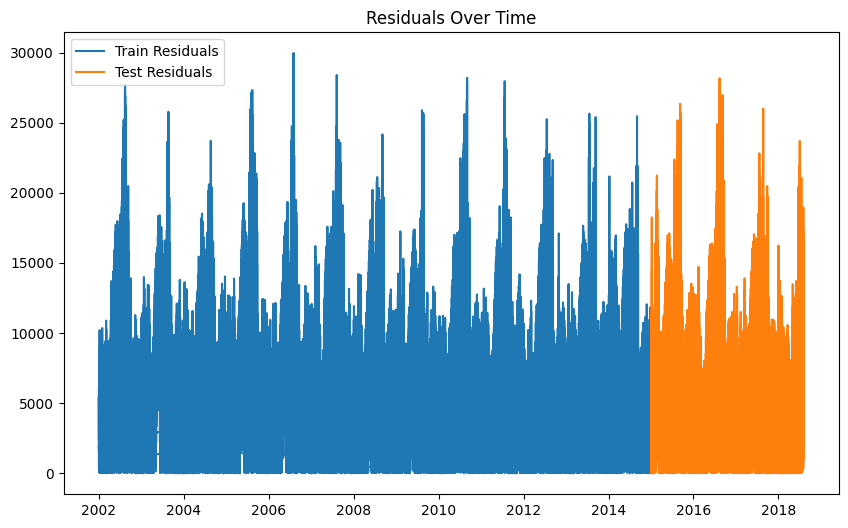

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(cleaned_train_set['ds'], residuals_train, label='Train Residuals')
plt.plot(test_set['ds'], residuals_test, label='Test Residuals')
plt.legend()
plt.title('Residuals Over Time')
plt.show()

In [ ]:
# Prepare features
for df in [cleaned_train_set, test_set]:
    df['lag1'] = df['y'].shift(1)
    df['lag24'] = df['y'].shift(24)
    df['hour'] = df['ds'].dt.hour
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['rolling_mean_24'] = df['y'].rolling(window=24).mean()
    
cleaned_train_set = cleaned_train_set.dropna()
test_set = test_set.dropna()
X_train = cleaned_train_set[['lag1', 'lag24', 'hour', 'day_of_week', 'rolling_mean_24']]

    
cleaned_train_set = cleaned_train_set.dropna()
test_set = test_set.dropna()
X_train = cleaned_train_set[['lag1', 'lag24', 'hour', 'day_of_week', 'rolling_mean_24']]
X_test = test_set[['lag1', 'lag24', 'hour', 'day_of_week', 'rolling_mean_24']]

# Drop NaN values from shifting
cleaned_train_set = cleaned_train_set.dropna()
test_set = test_set.dropna()

# Extract features and align with residuals
X_train = cleaned_train_set[['lag1', 'lag24', 'hour', 'day_of_week']]
X_test = test_set[['lag1', 'lag24', 'hour', 'day_of_week']]

# # Align residuals with feature indices
# residuals_train = residuals_train[:len(X_train)]  # Ensure same length
# residuals_test = residuals_test[:len(X_test)]

In [24]:
import optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }
    xgb_model = xgb.XGBRegressor(**params, objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train, residuals_train)
    residual_pred_test = xgb_model.predict(X_test)
    final_forecast_test = forecast_test['yhat'].iloc[:len(X_test)].values + residual_pred_test
    _, mape, _, _ = get_MAPE(
        cleaned_train_set,
        pd.DataFrame({'ds': test_set['ds'].iloc[:len(X_test)], 'y': actual_test}),
        pd.DataFrame({'ds': cleaned_train_set['ds'].iloc[:len(X_train)], 'yhat': final_forecast_train}),
        pd.DataFrame({'ds': test_set['ds'].iloc[:len(X_test)], 'yhat': final_forecast_test}),
        show=False
    )
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, residuals_train)

[I 2025-06-04 20:39:44,009] A new study created in memory with name: no-name-13859272-d4bd-4c25-8dca-5342ea24ab48
[W 2025-06-04 20:39:44,105] Trial 0 failed with parameters: {'n_estimators': 121, 'learning_rate': 0.11063709919625353, 'max_depth': 7} because of the following error: XGBoostError('[20:39:44] /Users/runner/work/xgboost/xgboost/src/data/data.cc:508: Check failed: this->labels.Size() % this->num_row_ == 0 (24 vs. 0) : Incorrect size for labels.\nStack trace:\n  [bt] (0) 1   libxgboost.dylib                    0x00000001206d6605 dmlc::LogMessageFatal::~LogMessageFatal() + 117\n  [bt] (1) 2   libxgboost.dylib                    0x0000000120897737 xgboost::MetaInfo::SetInfoFromHost(xgboost::Context const&, xgboost::StringView, xgboost::Json) + 3799\n  [bt] (2) 3   libxgboost.dylib                    0x0000000120896750 xgboost::MetaInfo::SetInfo(xgboost::Context const&, xgboost::StringView, xgboost::StringView) + 496\n  [bt] (3) 4   libxgboost.dylib                    0x00000001

XGBoostError: [20:39:44] /Users/runner/work/xgboost/xgboost/src/data/data.cc:508: Check failed: this->labels.Size() % this->num_row_ == 0 (24 vs. 0) : Incorrect size for labels.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001206d6605 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000120897737 xgboost::MetaInfo::SetInfoFromHost(xgboost::Context const&, xgboost::StringView, xgboost::Json) + 3799
  [bt] (2) 3   libxgboost.dylib                    0x0000000120896750 xgboost::MetaInfo::SetInfo(xgboost::Context const&, xgboost::StringView, xgboost::StringView) + 496
  [bt] (3) 4   libxgboost.dylib                    0x00000001206ed04c XGDMatrixSetInfoFromInterface + 236
  [bt] (4) 5   libffi.8.dylib                      0x0000000109311972 ffi_call_unix64 + 82
  [bt] (5) 6   ???                                 0x00007ff7b7361050 0x0 + 140701907423312



In [12]:
# Predict residuals on test set
residual_pred_train = xgb_model.predict(X_train)
residual_pred_test = xgb_model.predict(X_test)

# Combine with Prophet forecasts
# Ensure forecast_test['yhat'] aligns with X_test indices
final_forecast_train = forecast_train['yhat'].iloc[:len(X_train)].values + residual_pred_train
final_forecast_test = forecast_test['yhat'].iloc[:len(X_test)].values + residual_pred_test

In [17]:
# Extract actual values for comparison
actual_test = test_set['y'].iloc[:len(X_test)].values

# Verify alignment
assert len(X_train) == len(final_forecast_train), "X_train and final_forecast_train lengths mismatch"
assert len(X_test) == len(final_forecast_test), "X_test and final_forecast_test lengths mismatch"

# Calculate MAPE for the hybrid model
MAPE_train_hybrid, MAPE_test_hybrid, _, _ = get_MAPE(
    cleaned_train_set,
    pd.DataFrame({'ds': test_set['ds'].iloc[:len(X_test)], 'y': actual_test}),
    pd.DataFrame({'ds': cleaned_train_set['ds'].iloc[:len(X_train)], 'yhat': final_forecast_train}),
    pd.DataFrame({'ds': test_set['ds'].iloc[:len(X_test)], 'yhat': final_forecast_test}),
    show=True
)



Train set MAPE: 25.31%
Test set MAPE: 25.29%


In [28]:
print(f"X_train length: {len(X_train)}, final_forecast_train length: {len(final_forecast_train)}")
print(f"X_test length: {len(X_test)}, final_forecast_test length: {len(final_forecast_test)}")
print(f"cleaned_train_set length: {len(cleaned_train_set)}, test_set length: {len(test_set)}")

X_train length: 113568, final_forecast_train length: 113592
X_test length: 31392, final_forecast_test length: 31416
cleaned_train_set length: 113568, test_set length: 31392


In [19]:
residual_pred_train = xgb_model.predict(X_train)
residual_pred_test = xgb_model.predict(X_test)
print(f"Mean actual residual train: {np.mean(residuals_train):.2f}, Mean predicted residual train: {np.mean(residual_pred_train):.2f}")
print(f"Mean actual residual test: {np.mean(residuals_test):.2f}, Mean predicted residual test: {np.mean(residual_pred_test):.2f}")

Mean actual residual train: 5510.91, Mean predicted residual train: 5510.92
Mean actual residual test: 5420.23, Mean predicted residual test: 5554.00
